## Psych 253: Graph theory and network analysis

A graph is a formal description of a set of things (which we call *nodes*) and a set of relationships between them (which we call *edges*). There are many different types of data that can be represented as a graph, but generally they are of greatest interest in cases where most nodes are not connected to most other nodes; that is, they are *sparse*.  A *network* is mostly just another term for a graph; the field of *network science* is heavily focused on analyzing the structure of large graphs.

In Python there is a package called networkx that provides many tools for the analysis of graphs.  Whereas in the previous lectures we focused on directed graphs, here we will focus on *undirected* graphs -- that is, graphs where the edges don't have a direction. These edges are only meant to reflect a connection, without any claim regarding causality.



In [1]:
import os,sys
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import pickle 
import scipy.stats
import pkg_resources
import sys
import seaborn as sns
from inverse_covariance import QuicGraphicalLassoCV, QuicGraphicalLasso # pip  install skggm
from nilearn.plotting import plot_connectome
import h5py
import os
from pathlib import Path
import wget
from statsmodels.stats.multitest import fdrcorrection
from brainnetworks.utils import nx_to_igraph
from sklearn.covariance import GraphicalLassoCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import jaccard_score 


# you will need to install the brainnetworks package: pip install brainnetworks
from brainnetworks.utils import get_joint_pubs
DATA_PATH = pkg_resources.resource_filename('brainnetworks', 'data/')

%matplotlib inline

# fix random seeds for networkx
np.random.seed(42)
random.seed(42)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### Example 1: A simple graph

Let's create a graph representing the publication network between a number of neuroscientists.  

Each node in the graph will represent one of the individuals.  First we need to generate the graph object, and then add the nodes.

In [2]:
researchers={'DB': {'name': 'Danielle Bassett'},
            'AF': {'name': 'Alex Fornito'},
            'MB': {'name': 'Michael Breakspear'},
            'SP': {'name': 'Steve Petersen'},
            'MC': {'name': 'Michael Cole'},
            'JP': {'name': 'Jonathan Power'},
            'DF': {'name': 'Damien Fair'},
            'AZ': {'name': 'Andrew Zalesky'},
            'LC': {'name': 'Luca Cocchi'}}

G = nx.Graph()

G.add_nodes_from(researchers)

We can see the nodes using the nodes element in the graph object:

In [3]:
G.nodes

NodeView(('DB', 'AF', 'MB', 'SP', 'MC', 'JP', 'DF', 'AZ', 'LC'))

Each node in the graph can have attributes associated with it, which we can add to the nodes as we would add a dictionary element:

In [4]:
for researcher in researchers:
    G.nodes[researcher]['name'] = researchers[researcher]['name']
    print(researcher, G.nodes[researcher])

DB {'name': 'Danielle Bassett'}
AF {'name': 'Alex Fornito'}
MB {'name': 'Michael Breakspear'}
SP {'name': 'Steve Petersen'}
MC {'name': 'Michael Cole'}
JP {'name': 'Jonathan Power'}
DF {'name': 'Damien Fair'}
AZ {'name': 'Andrew Zalesky'}
LC {'name': 'Luca Cocchi'}


Let's visualize the graph so far using Networkx's visualization tools

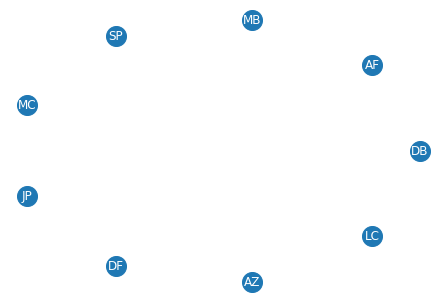

In [5]:
nx.draw_circular(G, with_labels=True, node_size=400, font_color='white')

So far we have a completely disconnected graph - that is, it has no edges (i.e. connections).  Now let's add edges based on the publication history.  First we will generate a matrix containing the number of joint publications between each of the researchers. 

In [6]:
# If the publication data are cached then load those and use them
# instead of getting them from pubmed

pubmed_file = pkg_resources.resource_filename('brainnetworks', 'data/pubmed/pubdata.pkl')
numpubs = pickle.load(open('data/pubmed/pubdata.pkl', 'rb'))

numpubs

{('DB', 'AF'): 2,
 ('DB', 'MB'): 1,
 ('DB', 'SP'): 1,
 ('DB', 'MC'): 3,
 ('DB', 'JP'): 2,
 ('DB', 'DF'): 0,
 ('DB', 'AZ'): 1,
 ('DB', 'LC'): 0,
 ('AF', 'MB'): 4,
 ('AF', 'SP'): 0,
 ('AF', 'MC'): 0,
 ('AF', 'JP'): 0,
 ('AF', 'DF'): 0,
 ('AF', 'AZ'): 30,
 ('AF', 'LC'): 13,
 ('MB', 'SP'): 0,
 ('MB', 'MC'): 0,
 ('MB', 'JP'): 0,
 ('MB', 'DF'): 0,
 ('MB', 'AZ'): 13,
 ('MB', 'LC'): 7,
 ('SP', 'MC'): 1,
 ('SP', 'JP'): 28,
 ('SP', 'DF'): 15,
 ('SP', 'AZ'): 0,
 ('SP', 'LC'): 0,
 ('MC', 'JP'): 2,
 ('MC', 'DF'): 0,
 ('MC', 'AZ'): 0,
 ('MC', 'LC'): 0,
 ('JP', 'DF'): 3,
 ('JP', 'AZ'): 0,
 ('JP', 'LC'): 0,
 ('DF', 'AZ'): 0,
 ('DF', 'LC'): 0,
 ('AZ', 'LC'): 25}

In [7]:
# create a list to use in making the matrix
# do this so that the order stays fixed
researchers_list = frozenset(researchers.keys()) 

# create a data frame to hold all of the entries
# for each combination of researchers

df = pd.DataFrame(np.zeros((len(researchers),
                            len(researchers))),
                  index=researchers_list,
                  columns=researchers_list)

# we just fill in the upper triangle of the matrix
for i, j in enumerate(researchers_list):
    for k in range(i, len(researchers_list)):
        if i == k:
            continue
        df.loc[j][k] = numpubs[(j, researchers_list[k])]

print(df)

     DB   AF   MB   SP   MC    JP    DF    AZ    LC
DB  0.0  2.0  1.0  1.0  3.0   2.0   0.0   1.0   0.0
AF  0.0  0.0  4.0  0.0  0.0   0.0   0.0  30.0  13.0
MB  0.0  0.0  0.0  0.0  0.0   0.0   0.0  13.0   7.0
SP  0.0  0.0  0.0  0.0  1.0  28.0  15.0   0.0   0.0
MC  0.0  0.0  0.0  0.0  0.0   2.0   0.0   0.0   0.0
JP  0.0  0.0  0.0  0.0  0.0   0.0   3.0   0.0   0.0
DF  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0
AZ  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0  25.0
LC  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0


Now let's use the co-publication matrix to generate a binary adjacency matrix, which will represent whether there is a link between each pair of investigators.  This is obtained by thresholding the co-publication matrix; for now we will just threshold at greater than zero, so that any publications are sufficient to create an edge.

In [8]:
threshold = 0
adjacency_mtx = (df > threshold).astype('int')
print(adjacency_mtx)

    DB  AF  MB  SP  MC  JP  DF  AZ  LC
DB   0   1   1   1   1   1   0   1   0
AF   0   0   1   0   0   0   0   1   1
MB   0   0   0   0   0   0   0   1   1
SP   0   0   0   0   1   1   1   0   0
MC   0   0   0   0   0   1   0   0   0
JP   0   0   0   0   0   0   1   0   0
DF   0   0   0   0   0   0   0   0   0
AZ   0   0   0   0   0   0   0   0   1
LC   0   0   0   0   0   0   0   0   0


Now let's use the adjacency matrix to determine which pairs have an edge, and then add those to the graph.

In [9]:
matches = np.where(adjacency_mtx > 0)
for i in range(len(matches[0])):
    G.add_edge(researchers_list[matches[0][i]],
               researchers_list[matches[1][i]])

Now we can see the edges as part of the graph object:

In [10]:
G.edges

EdgeView([('DB', 'AF'), ('DB', 'MB'), ('DB', 'SP'), ('DB', 'MC'), ('DB', 'JP'), ('DB', 'AZ'), ('AF', 'MB'), ('AF', 'AZ'), ('AF', 'LC'), ('MB', 'AZ'), ('MB', 'LC'), ('SP', 'MC'), ('SP', 'JP'), ('SP', 'DF'), ('MC', 'JP'), ('JP', 'DF'), ('AZ', 'LC')])

And we can now visualize the graph with the edges included.

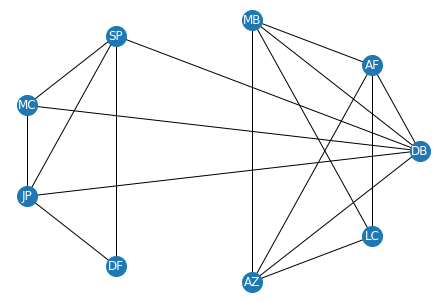

In [11]:
nx.draw_circular(G, with_labels=True, node_size=400, font_color='white')

The circular graph is not very useful because it's hard to see the structure of the network, because the edges are ordered arbitrarily (by the order in which we added them to the network).  Instead let's draw it using a spring embedding algorithm, which treats each edge as a spring and tries to minimize the force exerted on all of the springs taken together. 

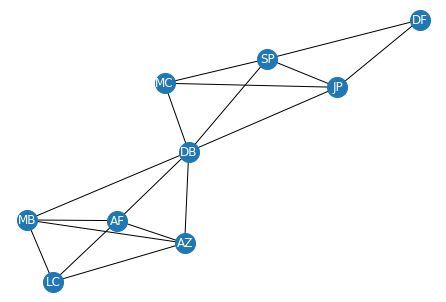

In [12]:
nx.draw_spring(G, with_labels=True, node_size=400, font_color='white')

### Node characteristics

Now that the graph is generated, we can examine the characteristics of some of the nodes.  First, let's look at the number of edges for each node - that is, its *degree*. This is stored in the degree element within the graph object.

In [13]:
G.degree

DegreeView({'DB': 6, 'AF': 4, 'MB': 4, 'SP': 4, 'MC': 3, 'JP': 4, 'DF': 2, 'AZ': 4, 'LC': 3})

We could also compute the degree by summing the adjacency matrix.  We first need to make it a symmetric matrix (since above we only included the upper triangle of the matrix) - we can do that by adding its transpose to the original matrix, and then summing across rows to get the degree.

In [14]:
adjacency_mtx_symm = adjacency_mtx + adjacency_mtx.T
adjacency_mtx_symm['degree'] = adjacency_mtx_symm.sum(1)
print(adjacency_mtx_symm)

    DB  AF  MB  SP  MC  JP  DF  AZ  LC  degree
DB   0   1   1   1   1   1   0   1   0       6
AF   1   0   1   0   0   0   0   1   1       4
MB   1   1   0   0   0   0   0   1   1       4
SP   1   0   0   0   1   1   1   0   0       4
MC   1   0   0   1   0   1   0   0   0       3
JP   1   0   0   1   1   0   1   0   0       4
DF   0   0   0   1   0   1   0   0   0       2
AZ   1   1   1   0   0   0   0   0   1       4
LC   0   1   1   0   0   0   0   1   0       3


It's also common to present the adjacency matrix as an image, with the color scale (usually black/white) denoting the presence/absence of connections. Note that by default we set the diagonal (i.e. self-connections) to zero.

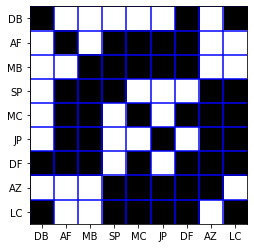

In [15]:
plt.imshow(adjacency_mtx +adjacency_mtx.T, cmap='gray')

# set the axes to use name labels rather than numbers
ax = plt.gca()
ax.set_yticks(np.arange(len(researchers_list)))
ax.set_xticks(np.arange(len(researchers_list)))
ax.set_xticklabels(researchers_list)
ax.set_yticklabels(researchers_list)
# add grid lines
for i in range(len(researchers_list)):
    ax.axvline(x=i - 0.5, color='b')
    ax.axhline(y=i - 0.5, color='b')

## Example 2: A realistic network

In this example we will use data from the myconnectome study to look at brain connectivity.



In [16]:
basedir = Path('data/myconnectome')

hdf5file = basedir / 'myconnectome_rsfmri.hdf5'

if not hdf5file.exists():
    print('data file does not exist, downloading... this might take a few minutes)')
    # download file from web
    if not os.path.exists('data/myconnectome'):
        os.makedirs('data/myconnectome')
    url = "https://web.stanford.edu/group/poldracklab/myconnectome-data/hdf5/myconnectome_rsfmri.hdf5"
    wget.download(url, 'data/myconnectome/myconnectome_rsfmri.hdf5')
    
with h5py.File(hdf5file,'r') as f:
    regions = f['parcellation']['region'][()]
    hemis = f['parcellation']['hemis'][()]
    power_network = f['parcellation']['power_network'][()]
    yeo7networks = f['parcellation']['yeo7networks'][()]
    coords = f['parcellation']['coords'][()]

    cc_triu = f['meancorr']['meancorr'][()]
    cc = np.zeros((630, 630))
    cc[np.triu_indices_from(cc, 1)] = cc_triu


    
labels = [f'{i}_{j}_{k}' for i, j, k in zip(hemis, power_network, regions)]
cc_full = pd.DataFrame(
    cc + cc.T + np.eye(cc.shape[0]),
    index=labels, columns=labels)
#sns.clustermap(cc_full, method='ward')

filling out ccmtx
Threshold for 2 percent density: 0.52


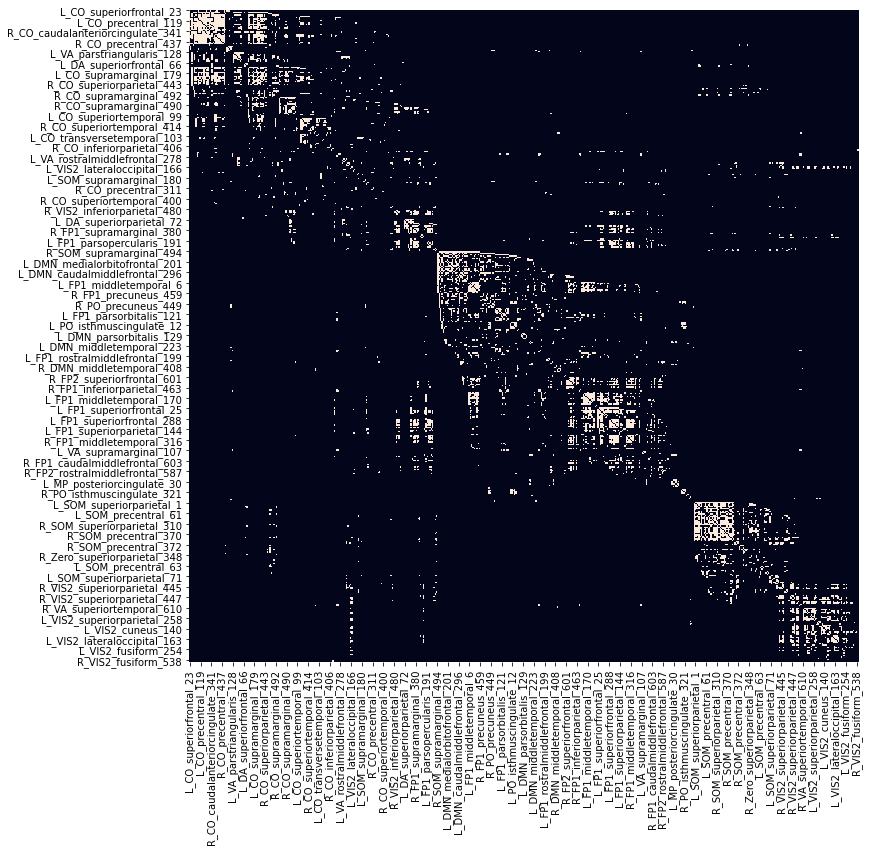

In [17]:
def create_graph_from_cc(hdf5file, ccmtx, density=5, sort_by=None):
    """
    create a networkx graph from a correlation matrix
    
    parameters:
    -----------
    hdf5file: string or Path, file containing myconnectome data
    ccmtx: pandas DataFrame, correlation matrix
    density: int or float, density of adjacency matrix (in percent)
    sort_by: 'yeo7', 'power', or None, network labels to sort by
    
    returns:
    --------
    Gc_fmri: a networkx graph with the giant component
    adj: the thresholded adjacency matrix
    """

    # load metadata from hdf5file
    with h5py.File(hdf5file,'r') as f:
        regions = f['parcellation']['region'][()]
        hemis = f['parcellation']['hemis'][()]
        power_network = f['parcellation']['power_network'][()]
        yeo7networks = f['parcellation']['yeo7networks'][()]
        coords = f['parcellation']['coords'][()]
    labels = []
    for n in range(len(regions)):
        labels.append(f'{hemis[n]}_{power_network[n]}_{regions[n]}_{n}')
    coords_df = pd.DataFrame(coords, index=labels)
    
    cc = ccmtx.copy()

    # ensure that cc is symmetric and zero-diagonal
    if np.sum(cc[np.tril_indices_from(cc)]) == 0 or np.sum(cc[np.triu_indices_from(cc, 1)]) == 0:
        print('filling out ccmtx')
        cc = cc + cc.T
    cc[np.diag_indices_from(cc)] = 0

    # create adjacency matrix from correlation matrix
    cc_triu = cc[np.triu_indices_from(cc, 1)]
    thresh = scipy.stats.scoreatpercentile(cc_triu, 100 - density)
    if thresh == 0: # deal with case where thresh is zero
        thresh = 1e-8
    print(f'Threshold for {density} percent density: {thresh:0.2f}')

    
    adj = pd.DataFrame(
        (cc >= thresh).astype(int),
        index=labels,
        columns=labels)
    adj['yeo7networks'] = yeo7networks
    adj['power_network'] = power_network
    adj['hemis'] = hemis
    if sort_by is not None:
        assert sort_by in ['yeo7networks', 'power_network']

        
        adj_sorted_rows = adj.sort_values([sort_by, 'hemis'], axis=0).drop(
            ['yeo7networks', 'power_network', 'hemis'], axis=1).T
        adj_sorted_rows.index = labels
        adj_sorted_rows['yeo7networks'] = yeo7networks
        adj_sorted_rows['power_network'] = power_network
        adj_sorted_rows['hemis'] = hemis
        
        adj = adj_sorted_rows.sort_values([sort_by, 'hemis'], axis=0)
        
    # create graph
    G = nx.Graph()
    
    node_names = adj.columns.tolist()
    adj_values = adj.drop(['yeo7networks', 'power_network', 'hemis'], axis=1).values
    adj_values[np.tril_indices_from(adj_values)] = 0
    adjacencies = np.where(adj_values)

    for i in range(adjacencies[0].shape[0]):
        G.add_edge(adjacencies[0][i], adjacencies[1][i])

    # add labels for nodes
    for i in G.nodes:
        G.nodes[i]['name'] = adj.index[i]
        G.nodes[i]['power_network'] = adj.loc[adj.index[i], 'power_network'] 
        G.nodes[i]['yeo7networks'] = adj.loc[adj.index[i], 'yeo7networks']
        G.nodes[i]['coords'] = coords_df.loc[adj.index[i], :].values # power_network[i]

    # extract the giant component
    Gc_fmri = G.subgraph(max(nx.connected_components(G), key=len)).copy() 
    Gc_fmri_node_names = [Gc_fmri.nodes[i]['name'] for i in Gc_fmri.nodes]
    adj_gc = pd.DataFrame(nx.to_numpy_array(Gc_fmri), 
                          index=Gc_fmri_node_names,
                          columns=Gc_fmri_node_names)
    return(Gc_fmri, adj_gc) #adj.drop(['yeo7networks', 'power_network', 'hemis'], axis=1))

density = 2 # in percent

Gc_fmri, gc_adj = create_graph_from_cc(hdf5file, cc, density=density, sort_by='power_network')
plt.figure(figsize=(12, 12))
sns.heatmap(gc_adj, cbar=False)

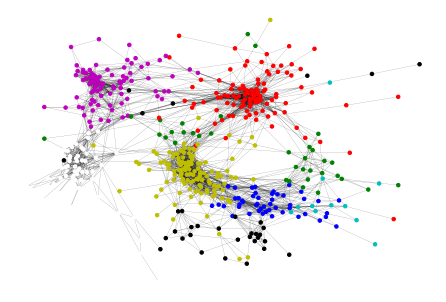

In [18]:
# use existing networks to color edges

node_color_dict = {
    'CO': 'r', 
    'DA': 'g', 
    'DMN': 'b', 
    'FP1': 'y', 
    'FP2': 'y', 
    'MP': 'k', 
    'PO': 'k', 
    'SAL': 'c', 
    'SOM': 'm', 
    'VA': 'g',
    'VIS1': 'w', 
    'VIS2': 'w',
    'Zero': 'k', 
    'na': 'k'
}

node_colors = [node_color_dict[Gc_fmri.nodes[i]['power_network']] for i in Gc_fmri.nodes]

# networkx uses a combination of numpy and random, need to set both seeds
seed = 123
random.seed(seed)
np.random.seed(seed)

# generate the layout separately, so we can reuse it below
spring_layout = nx.spring_layout(Gc_fmri)

# draw the graph using power network colors
nx.draw(Gc_fmri,
        pos=spring_layout,
        node_size=12,
        width=0.1,
        node_color=node_colors)

We can also use the actual locations of the nodes to visualize their location in the brain, by generating our own networkx layout using the coordinates of each brain area:

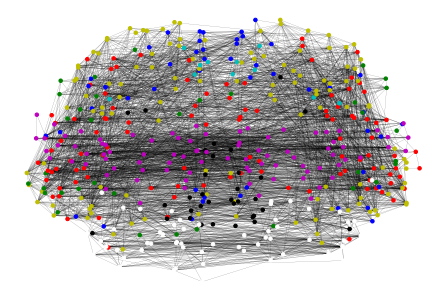

In [19]:
anat_layout = {'xy': {}, 'yz': {}}

for i in spring_layout:
    anat_layout['xy'][i] = Gc_fmri.nodes[i]['coords'][:2]
    
# draw the graph using power network colors
nx.draw(Gc_fmri,
        pos=anat_layout['xy'],
        node_size=12,
        width=0.1,
        node_color=node_colors)



Here you can see that there are a substantial number of bilateral connections, as well as a large number of connections spanning from front to back.

We can also plot three projections through the brain using the nilearn `plot_connectome` function:

In [20]:
Gc_adj = nx.to_numpy_array(Gc_fmri)
Gc_coords = [Gc_fmri.nodes[i]['coords'] for i in Gc_fmri.nodes]

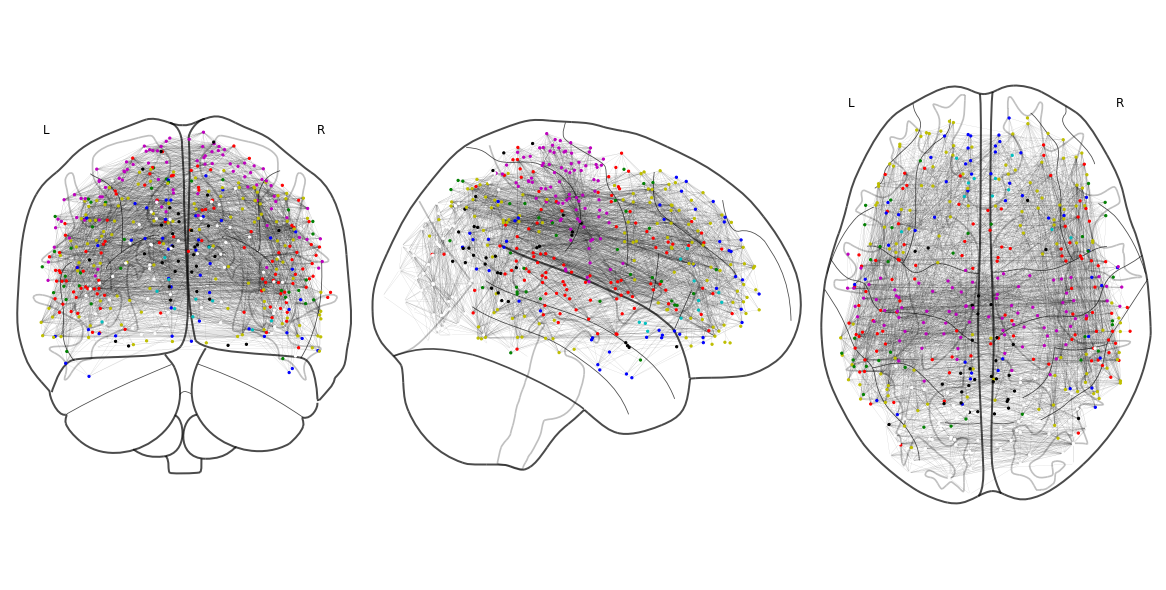

In [21]:
fig = plt.figure(figsize=(16,8))
plot_connectome(Gc_adj, Gc_coords, node_size=5, 
                edge_kwargs = {'linewidth': .05, 'color': 'black'},
                node_color=node_colors,
                figure=fig)

## Degree distribution



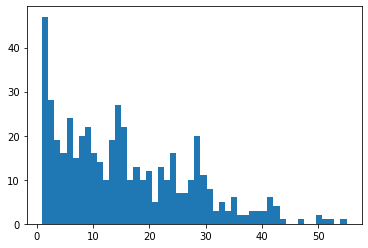

In [22]:
degree = [Gc_fmri.degree[i] for i in dict(nx.degree(Gc_fmri))]

_ = plt.hist(degree, 50)

This distribution is slightly long-tailed but far from the power-like distributions often seen with some real-world networks.  For example, here is the degree distribution from a Facebook 

mean degree: 43.69101262688784
max degree: 1045


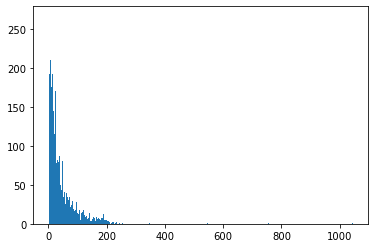

In [23]:
import pkg_resources
facebook_file = pkg_resources.resource_filename('brainnetworks', 'data/facebook/facebook_combined.txt')

facebook_data = pd.read_csv(facebook_file,sep=' ',
                             header=None)
# generate a networkx graph
G_facebook = nx.Graph()
for i in facebook_data.index:
    G_facebook.add_edges_from([tuple(facebook_data.loc[i])])

degree_vals = [G_facebook.degree[i] for i in G_facebook.nodes]
degree_dist = plt.hist(degree_vals,500)
print('mean degree:',np.mean(degree_vals))
print('max degree:',np.max(degree_vals))


## Partial correlation/inverse covariance

Many of the networks analyzed within network science are based on binary measures (such as Facebook friendship), where an edge either exists or it does not.  However, in data analysis we are often forced to generate networks based on continuous measures of relationships, such as correlation.  One challenge with using correlation to estimate a network is that correlation values can reflect either direct or indirect connections between nodes, as well confounds that affect multiple nodes.  One solution to this problem is to instead generate the network using the *partial correlation* (or *inverse covariance*) --- that is, the correlation between nodes X and Y after partialling out the variance shared with all other nodes. 

Let's first look at this using simulated data (based on the [sklearn tutorial](https://scikit-learn.org/stable/auto_examples/covariance/plot_sparse_cov.html)).

In [24]:
from sklearn.datasets import make_sparse_spd_matrix

# Generate the data
n_samples = 60
n_features = 20

prng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features, alpha=.95,
                              smallest_coef=.4,
                              largest_coef=.8,
                              random_state=prng)
cov = np.linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
X -= X.mean(axis=0)
X /= X.std(axis=0)

# Estimate the covariance
emp_cov = np.dot(X.T, X) / n_samples


Text(0.5, 1.0, 'empirical covariance')

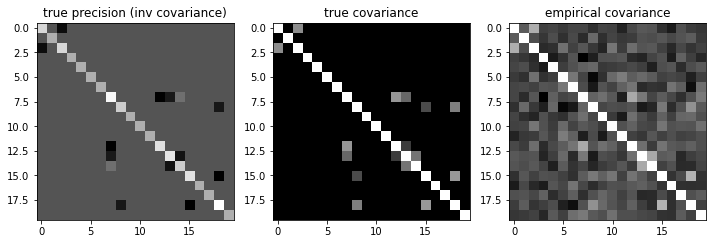

In [25]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(prec, cmap='gray')
plt.title('true precision (inv covariance)')
plt.subplot(1,3,2)
plt.imshow(cov, cmap='gray')
plt.title('true covariance')
plt.subplot(1,3,3)
plt.imshow(emp_cov, cmap='gray')
plt.title('empirical covariance')


The partial correlation is directly related to the inverse of the covariance matrix, and in machine learning often goes by the name of "inverse covariance estimation".  First let's see what happens if we try to simply take the inverse of the covariance matrix to retrieve the true covariances:

Text(0.5, 1.0, 'estimated inverse covariance')

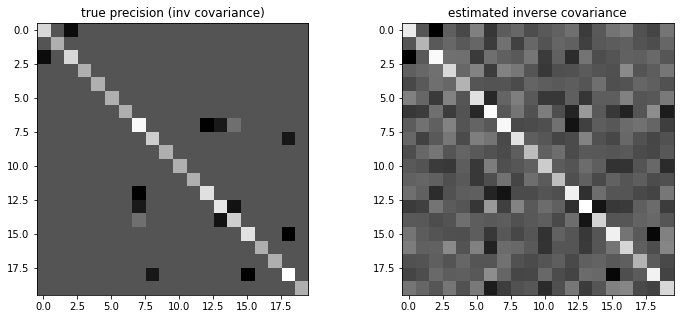

In [26]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(prec, cmap='gray')
plt.title('true precision (inv covariance)')
plt.subplot(1,2,2)
# estimate inverse covariance by inverting the empirical covariance
icov = np.linalg.inv(emp_cov)
plt.imshow(icov, cmap='gray')
plt.title('estimated inverse covariance')


Because the number of samples is relatively small compared to the number of features, the inversion of the covariance matrix is unstable, and the resulting inverse covariances are very noisy.  In order to improve estimation of the inverse covariance, we can *regularize* the estimates, using either an L1 or L2 penalty.  Here we will examine the *graphical lasso*, which estimates the inverse covariance using an L1 penalty.  We will use the `QuicGraphicalLassoCV()` object from skggm package, which uses an inner crossvalidation loop to select the optimal regularization parameter. The algorithm used here is much more stable than the one implemented in scikit-learn with large numbers of features.

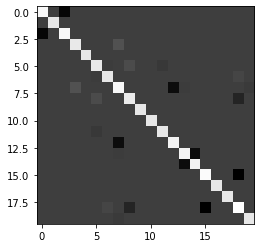

In [27]:
model = QuicGraphicalLassoCV()
model.fit(X)
cov_ = model.covariance_
prec_ = model.precision_
plt.imshow(prec_, cmap='gray')

This analysis is able to retrieve the true precision used to generate the data, albeit with a few errors.

Let's try this on the myconnectome data, using the timeseries data from the first 20 sessions. This model can take several hours to fit, so we will use a cached version of the results if it exists.

In [28]:
from sklearn.model_selection import ShuffleSplit


def get_myconnectome_split(hdf5file, seed=None, test_size=0.5):
    """
    function to extract resting state timeseries from hdf5 file
    
    parameters:
    -----------
    hdf5file: string or Path, link to data file
    seed: random seed, set to None to use system time
    test_size: proportion of dataset to allocate to test
        - for full dataset set test_size=0
        
    returns:
    --------
    tsdata: dictionary containing two arrays ('train', and 'test')
    """
    rng = np.random.RandomState(seed)
    if test_size > 0:
        ss = ShuffleSplit(n_splits = 1, test_size = test_size, random_state=rng)
        X = np.arange(84)[:, np.newaxis]

    with h5py.File(hdf5file,'r') as f:
        sessions = [i for i in f['timeseries'].keys()]
        sessions.sort()
        tsdata={}
        
        if test_size > 0:
            for train_index, test_index in ss.split(X):
                for i in train_index:
                    s = sessions[i]
                    if 'train' not in tsdata:
                        tsdata['train'] = f['timeseries'][s][()]
                    else:
                        tsdata['train'] = np.vstack((tsdata['train'], f['timeseries'][s][()]))
                for i in test_index:
                    s = sessions[i]
                    if 'test' not in tsdata:
                        tsdata['test'] = f['timeseries'][s][()]
                    else:
                        tsdata['test'] = np.vstack((tsdata['test'], f['timeseries'][s][()]))
        else: # full dataset as train
                for i in range(len(sessions)):
                    s = sessions[i]
                    if 'train' not in tsdata:
                        tsdata['train'] = f['timeseries'][s][()]
                    else:
                        tsdata['train'] = np.vstack((tsdata['train'], f['timeseries'][s][()]))
                tsdata['test'] = None
    print(tsdata['train'].shape)
    
    if tsdata['test'] is not None:
        print(tsdata['test'].shape)
    else:
        print('no test data')
    return(tsdata)



In [29]:
path = np.arange(0.2, 0.02, -0.01)
quic_pkl = Path('quic_myconnectome.pkl')
if quic_pkl.exists():
    with open(quic_pkl, 'rb') as f:
        qgl = pickle.load(f)
else:
    tsdata = get_myconnectome_split(hdf5file, seed=1, test_size=0)  
    # use the lasso path, which gives us estimates for many different lambas
    # in an efficient way
    qgl = QuicGraphicalLasso(lam=1, path=path, mode='path')
    qgl.fit(tsdata['train'])
    with open(quic_pkl, 'wb') as f:
        pickle.dump(qgl, f)
    


In [30]:
# get densities at each lambda, and find the lambda that
# best matches our intended density

thresh = density / 100 # proportion threshold

under_thresh = []

for i, lam in enumerate(path):
    prec_ = qgl.precision_[i]
    prec_utri = prec_[np.triu_indices_from(prec_, 1)]
    utri_density = np.mean(prec_utri>0)
    print(lam, utri_density)
    if utri_density < thresh:
        under_thresh.append(lam)

best_lam = np.min(under_thresh)
best_idx = np.where(path==best_lam)[0][0]
print('selection:', best_lam, best_idx)

0.2 0.007070936482701189
0.19 0.007691725338784162
0.18 0.008428596663890781
0.16999999999999998 0.009261362202538674
0.15999999999999998 0.010109268932798345
0.14999999999999997 0.010997552174022762
0.13999999999999996 0.011890882479117773
0.12999999999999995 0.012935624700330583
0.11999999999999994 0.014338708456355514
0.10999999999999993 0.015842733489792312
0.09999999999999992 0.017689958866429455
0.08999999999999991 0.01990057284174931
0.0799999999999999 0.022545234309940192
0.0699999999999999 0.025967143614202437
0.05999999999999989 0.030484265778383427
0.04999999999999988 0.03642970701794231
0.03999999999999987 0.04526206879148056
0.02999999999999986 0.058000858000858004
selection: 0.08999999999999991 11


Text(0.5, 1.0, 'estimated inverse covariance')

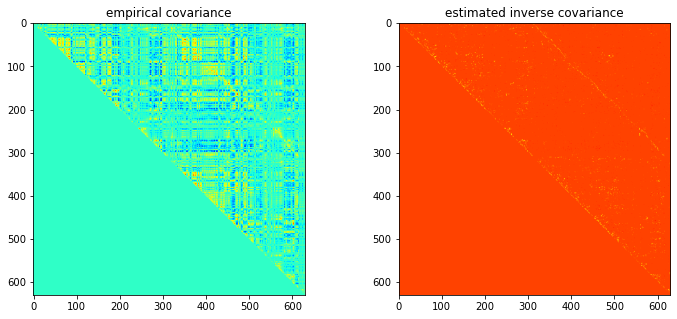

In [31]:
cov_ = qgl.covariance_[best_idx]
prec_ = qgl.precision_[best_idx]
prec_[np.tril_indices_from(prec_)] = 0
cov_[np.tril_indices_from(cov_)] = 0

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(cov_, cmap='jet')
plt.title('empirical covariance')
plt.subplot(1,2,2)
plt.imshow(prec_, cmap='jet')
plt.title('estimated inverse covariance')

In [32]:
prec_.shape

(630, 630)

filling out ccmtx
Threshold for 2 percent density: 0.00


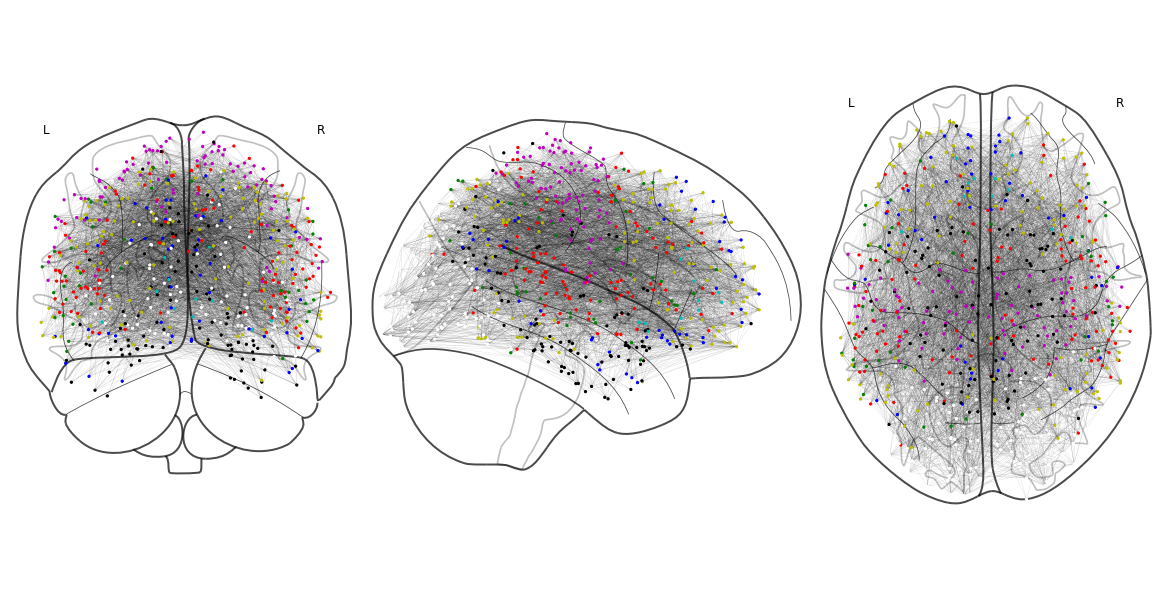

In [33]:
G_glasso, adj_glasso = create_graph_from_cc(hdf5file, prec_, density=density)
coords_glasso = [G_glasso.nodes[i]['coords'] for i in G_glasso.nodes]

anat_layout_glasso = {}
for i in G_glasso.nodes:
    anat_layout_glasso[i] = coords[i, :2]

node_colors_glasso = [node_color_dict[i] for i in power_network[[j for j in G_glasso.nodes]]]

fig = plt.figure(figsize=(16, 8))
plot_connectome(adj_glasso, coords_glasso, node_size=5, 
                edge_kwargs = {'linewidth': .05, 'color': 'black'},
                node_color=node_colors_glasso,
                figure=fig)


Here we see that the connections identified using this method are much less anatomically coherent than those identified using full correlation.

One thing that we can do to assess this is to assess the degree to which these connnections map onto the known functional networks of the brain.  Keep in mind, of course, that those "known functional networks" are based on previous studies that used standard Pearson correlation to define them!

In [34]:
power_networks_clean = np.unique(power_network).tolist()
power_networks_clean.remove('na')
power_networks_clean.remove('Zero')
networks_fullcorr_df = pd.DataFrame(np.zeros((len(power_networks_clean), 
                                              len(power_networks_clean))),
                                    index=power_networks_clean,
                                    columns=power_networks_clean)

for i in Gc_fmri.edges:
    from_net = Gc_fmri.nodes[i[0]]['power_network']
    to_net = Gc_fmri.nodes[i[1]]['power_network']
    try:
        networks_fullcorr_df.loc[from_net, to_net] += 1
    except KeyError:
        # skip excluded networks
        pass
    
    
networks_pcorr_df = pd.DataFrame(np.zeros((len(power_networks_clean), 
                                           len(power_networks_clean))),
                                 index=power_networks_clean,
                                 columns=power_networks_clean)

for i in G_glasso.edges:
    from_net = G_glasso.nodes[i[0]]['power_network']
    to_net = G_glasso.nodes[i[1]]['power_network']
    try:
        networks_pcorr_df.loc[from_net, to_net] += 1
    except KeyError:
        # skip excluded networks
        pass

# scale by rows
networks_fullcorr_df = networks_fullcorr_df.div(networks_fullcorr_df.sum(axis=1), axis=0)
networks_pcorr_df = networks_pcorr_df.div(networks_pcorr_df.sum(axis=1), axis=0)

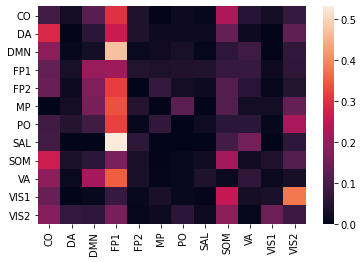

In [35]:
sns.heatmap(networks_pcorr_df)

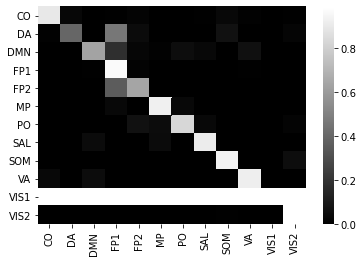

In [36]:
sns.heatmap(networks_fullcorr_df, cmap='gray')

### Community detection methods

First let's create a simple graph that has two communities, each of which is fully connected, with one node from each community connected to a node in the other community.

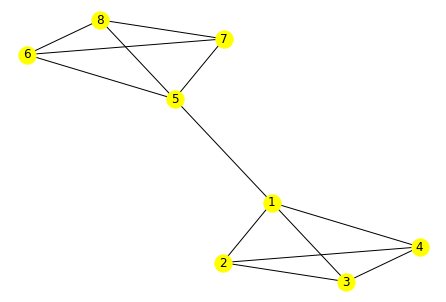

In [37]:
G = nx.Graph()
# nodes 1-4 are members of one community, and 5-8 are members of another, with 1 and 5 connected as well
edges = [(1, 2), (1, 3), (1, 4), (1, 5), (5, 6), (5, 7), (5, 8), 
         (6, 7), (6, 8), (7, 8), (2, 3), (2, 4), (3, 4)]
G.add_edges_from(edges)

nx.draw_spring(G, with_labels=True, node_color='yellow')

### Girvan-Newman method

The Girvan-Newman method is a *divisive* clustering method, meaning that it starts with the full graph and tries to find the best way to divide it into some number of clusters by removing particular edges.

The algorithm was defined by [Girvan & Newman (2002)](http://www.pnas.org/content/99/12/7821) as follows:

1. Calculate the betweenness for all edges in the network.
2. Remove the edge with the highest betweenness.
3. Recalculate betweennesses for all edges affected by the
removal.
4. Repeat from step 2 until no edges remain.

Let's implement this for the example dataset, finding two clusters.

In [38]:
import operator 
import itertools

n_clusters = len([i for i in nx.connected_components(G)])
G_tmp = G.copy()  # make a copy of the graph to work with
while n_clusters == 1:
    # step 1: compute edge betweenness
    eb=nx.edge_betweenness(G_tmp)
    
    # step 2: remove the edge with highest betweeness
    # find the edge with the largest value of edge betweenness
    ebmax = max(eb.items(), key=operator.itemgetter(1))[0]
    # remove it from the graph
    G_tmp.remove_edges_from([ebmax])
    print('removing edge:', ebmax)
    
    # compute the number of connected components to see if we have
    # induced new clusters, and continue looping if not
    n_clusters=len([i for i in nx.connected_components(G_tmp)])
    
print('found two clusters:')
Gc = G.subgraph(max(nx.connected_components(G), key=len)).copy() 
print([list(G.subgraph(i).nodes) for i in nx.connected_components(G_tmp)])

removing edge: (1, 5)
found two clusters:
[[1, 2, 3, 4], [5, 6, 7, 8]]


### Modularity

One of the most commonly used set of methods for community detection rely upon the concept of *modularity*.  Here we will walk through the computation of modularity for a simple graph.

Here is one expression for modularity, from [Fortunato, 2010](https://arxiv.org/pdf/0906.0612.pdf):

$$
Q = \frac{1}{2m}\sum_{ij}(A_{ij} - P_{ij})\delta(C_i,C_j)
$$

where $m$ is the total number of edges in the graph, $A$ is the adjacency matrix, and $P_{ij}$ is the expected number of edges between i and j according to the apporpriate null model, and $\delta$ is a matrix that denotes whether vertices i and j are within the same community:

$$
\delta(C_i,C_j) = \left\{
                \begin{array}{ll}
                  1\ if\ C_i=C_j\\
                  0\ if\ C_i \neq C_j\\
                \end{array}\right.
$$

To compute modularity for our example graph (which looks to be fairly modular), we first need the adjacency matrix.

In [39]:
A = nx.to_numpy_array(G)
print(A)

[[0. 1. 1. 1. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1. 1. 0.]]


Next we need to generate the $\delta$ matrix denoting whether each pair of vertices is a member of the same community.

In [40]:
partition = [1,1,1,1,2,2,2,2]
delta = np.zeros((len(partition),len(partition)))
for i in range(len(partition)):
    for j in range(len(partition)):
        delta[i,j] = int(partition[i] == partition[j])
        
print(delta)

[[1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]


The final thing we need is the expected edge frequency from the null model.  In general we want the null model to match the actual graph as closely as possible, except for the clustering. It is common to use a null model in which the degree sequence (i.e. the values of degrees for all nodes) is identical to the real graph; this is a more stringent null model than simply equating the degree distribution.  This null model can be written as (Fortunato, 2010):

$$
Q = \frac{1}{2m}\sum_{ij}\bigg(A_{ij} - \frac{k_i k_j}{2m}\bigg)\delta(C_i,C_j)
$$

where $k_i$ is the degree of vertex $i$.  Note that this null model will not necessarily give an identical degree sequence on any particular realization, but should be the same on average.

In [41]:
m = len(G.edges)
k = [G.degree[i] for i in G.nodes] # degree values
Q = 0
for i in range(len(k)):
    for j in range(len(k)):
        Q += (A[i, j] - (k[i] * k[j]) / (2 * m)) * delta[i, j]
Q = Q / (2 * m)

print(Q)

0.42307692307692296


We can compare our answer to the one given by the built-in modularity function in NetworkX:

In [42]:
assert Q == nx.algorithms.community.quality.modularity(G,[{1, 2, 3, 4}, {5, 6, 7, 8}])

Now let's examine how modularity varies with the partition.  In this case, we can fairly easily compute all 128 possible partitions of the 8 nodes and compute modularity for each.  In principle we should see that the modularity value is highest for the true partition.

In [43]:
from brainnetworks.utils import algorithm_u

Qvals_all = np.zeros(128)
partitions = []

# loop through all possible partitions of edges into two communities:
for i,p in enumerate(algorithm_u([1, 2, 3, 4, 5, 6, 7, 8], 2)):
    Qvals_all[i] = nx.algorithms.community.quality.modularity(G, p)
    partitions.append(p)

maximum Q: 0.42307692307692296
best partition: [[1, 2, 3, 4], [5, 6, 7, 8]]


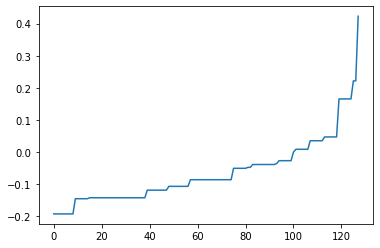

In [44]:
plt.plot(np.sort(Qvals_all))
print('maximum Q:', np.max(Qvals_all))
print('best partition:', partitions[np.argsort(Qvals_all)[-1:][0]])

### Modularity optimization

In general, it's not possible to perform exhaustive computation of modularity for all possible partitions (since the number of possible partitions grows exponentially with the size of the graph), so a number of researchers have developed approximate methods that perform well in finding the partition with the maximum modularity value.

#### Greedy optimization

One approach (proposed initially by [Newman, 2004](https://pdfs.semanticscholar.org/29d4/dfae2807a67a2c66c720b4985cb599c4e245.pdf)) is to perform an *agglomerative* clustering using a ["greedy" algorithm ](https://en.wikipedia.org/wiki/Greedy_algorithm)- that is, an algorithm that makes the best possible choice at each point in the process, akin to climbing a hill by going the steepest upward direction at every point.

In Newman's greedy method, we start with each vertex in its own partition. We then find which combination of partitions would increase modularity the most, and combine those into one.

The implementation here would be far too inefficient to use with real data, but should help make clear how the algorithm works.

In [45]:
# create a function to compute modularity more easily
def modularity(G,partition):
    A = nx.to_numpy_array(G)
    m = len(G.edges)
    delta = np.zeros((len(partition), len(partition)))
    for i in range(len(partition)):
        for j in range(len(partition)):
            delta[i, j]=int(partition[i] == partition[j])
   
    k = [G.degree[i] for i in G.nodes] # degree values
    Q = 0
    for i in range(len(k)):
        for j in range(len(k)):
            Q += (A[i, j] - (k[i] * k[j]) / (2 * m))*delta[i, j]
    Q = Q / (2 * m)
    return(Q)

Qvals = [-np.inf]
notbest = True
partition = np.array([1, 2, 3, 4, 5, 6, 7, 8])  # initially assign all to the same

while notbest:
    unique_partitions = np.unique(partition)
    print('unique partitions:', unique_partitions)
    # loop through all combinations of unique partitions
    modvals={}
    for i in range(len(unique_partitions)):
        for j in range(i+1, len(unique_partitions)):
            if i == j:
                continue
            tmp_part = np.array(partition)
            tmp_part[tmp_part == unique_partitions[i]] = unique_partitions[j]
            
            modvals[(unique_partitions[i], unique_partitions[j])] = modularity(G, tmp_part)
    modmax = max(modvals.items(), key=operator.itemgetter(1))[0]
    
    # this method assumes that Q increases monotonically to its maximum
    if modvals[modmax] < np.max(np.array(Qvals)):
        print('breaking: found best Q value!')
        print(partition)
        notbest = False
    else:
        print('collapsing:', modmax,modvals[modmax])
        partition[partition == modmax[0]] = modmax[1]
        print('new partition:', partition)
        print('')
        Qvals.append(modvals[modmax])

unique partitions: [1 2 3 4 5 6 7 8]
collapsing: (2, 3) -0.07692307692307693
new partition: [1 3 3 4 5 6 7 8]

unique partitions: [1 3 4 5 6 7 8]
collapsing: (3, 4) 0.02366863905325443
new partition: [1 4 4 4 5 6 7 8]

unique partitions: [1 4 5 6 7 8]
collapsing: (1, 4) 0.14792899408284027
new partition: [4 4 4 4 5 6 7 8]

unique partitions: [4 5 6 7 8]
collapsing: (6, 7) 0.19822485207100599
new partition: [4 4 4 4 5 7 7 8]

unique partitions: [4 5 7 8]
collapsing: (7, 8) 0.2988165680473374
new partition: [4 4 4 4 5 8 8 8]

unique partitions: [4 5 8]
collapsing: (5, 8) 0.42307692307692296
new partition: [4 4 4 4 8 8 8 8]

unique partitions: [4 8]
breaking: found best Q value!
[4 4 4 4 8 8 8 8]


### Spectral clustering

Another common method for community detection is spectral clustering, which uses the eigenvectors of matrices that describe the graph.  While we could work with the adjacency matrix, it is more common to use the [Laplacian matrix](https://samidavies.wordpress.com/2016/09/20/whats-up-with-the-graph-laplacian/), which you can think of as describing the flow of some quantity away from any particular node in the graph.

The Laplacian L is defined as:

$$
L = D - A
$$ 

where $A$ is the adjacency matrix, and $D$ is a diagonal matrix where each entry is the degree of that particular node. Here it is for our example graph:

In [46]:
D = np.zeros(A.shape)
D[np.diag_indices_from(D)] = k
L = D - A
print(L)

[[ 4. -1. -1. -1. -1.  0.  0.  0.]
 [-1.  3. -1. -1.  0.  0.  0.  0.]
 [-1. -1.  3. -1.  0.  0.  0.  0.]
 [-1. -1. -1.  3.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  4. -1. -1. -1.]
 [ 0.  0.  0.  0. -1.  3. -1. -1.]
 [ 0.  0.  0.  0. -1. -1.  3. -1.]
 [ 0.  0.  0.  0. -1. -1. -1.  3.]]


In general, it's more useful to work with the normalized Laplacian, which normalizes by degree. We can compute this easily using linear algebra:

$$
Ln = D^{-\frac{1}{2}}LD^{-\frac{1}{2}}
$$

In [47]:
Ln = np.linalg.inv(np.sqrt(D)).dot(L).dot(np.linalg.inv(np.sqrt(D)))
print(Ln)

[[ 1.         -0.28867513 -0.28867513 -0.28867513 -0.25        0.
   0.          0.        ]
 [-0.28867513  1.         -0.33333333 -0.33333333  0.          0.
   0.          0.        ]
 [-0.28867513 -0.33333333  1.         -0.33333333  0.          0.
   0.          0.        ]
 [-0.28867513 -0.33333333 -0.33333333  1.          0.          0.
   0.          0.        ]
 [-0.25        0.          0.          0.          1.         -0.28867513
  -0.28867513 -0.28867513]
 [ 0.          0.          0.          0.         -0.28867513  1.
  -0.33333333 -0.33333333]
 [ 0.          0.          0.          0.         -0.28867513 -0.33333333
   1.         -0.33333333]
 [ 0.          0.          0.          0.         -0.28867513 -0.33333333
  -0.33333333  1.        ]]


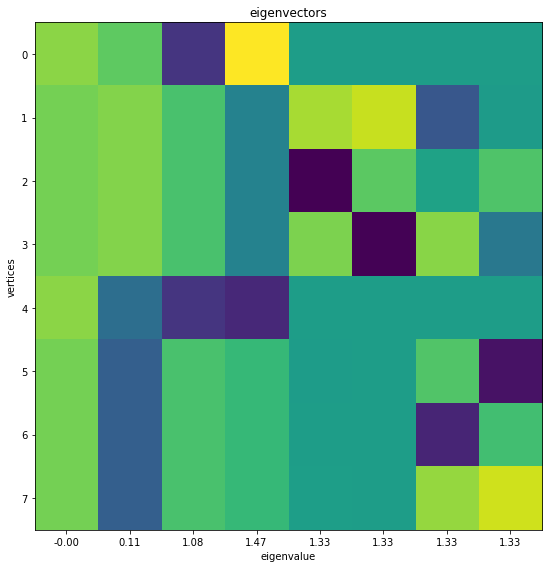

In [48]:
eig = np.linalg.eig(Ln)
def plot_eig(eig):
    plt.figure(figsize=(8, 8))
    plt.imshow(eig[1])       # Get locations and labels
    _=plt.xticks([i for i in range(len(eig[0]))], ['%0.2f' % i for i in eig[0]])
    plt.xlabel('eigenvalue')
    plt.ylabel("vertices")
    plt.title('eigenvectors')
    plt.tight_layout()
    
plot_eig(eig)

Note that there is a single zero eigenvalue, which represents the fact that there is a single graph component.  Let's see what would happen if we were to add another component:

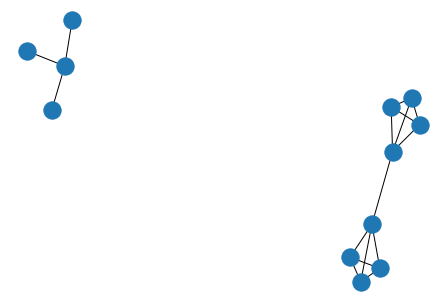

In [49]:
G_bigger = G.copy()
G_bigger.add_edges_from([(9, 10), (10, 11), (10, 12)])
nx.draw_spring(G_bigger)

Now let's get the Laplacian matrix (this time using the built-in NetworkX function) and compute its eigenvalues.

In [50]:
Ln_bigger = nx.normalized_laplacian_matrix(G_bigger).todense()
eig_bigger = np.linalg.eig(Ln_bigger)
eig_bigger[0]

array([-1.38777878e-17,  1.13382475e-01,  1.08333333e+00,  1.46995086e+00,
        1.33333333e+00,  1.33333333e+00,  1.33333333e+00,  1.33333333e+00,
        2.00000000e+00,  1.00000000e+00, -1.00275610e-16,  1.00000000e+00])

Here you can see that there are two zero-valued eigenvalues, reflecting the fact that there are two components.

Now look back at the second column in the eigenvector matrix above, corresponding to the second largest eigenvalue.  Let's draw the graph and color the nodes according to the values of this second smallest eigenvalue:

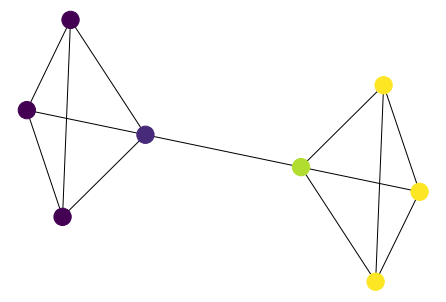

In [51]:
nx.draw_spring(G, node_color=eig[1][:, 1], cmap='viridis')

What this shows is that the eigenvector corresponding to the smallest nonzero eigenvalue of the Laplacian matrix divides the graph by its major communities.

Spectral clustering methods take this approach further by treating each vertex in a metric space defined by the eigenvectors, and then using these to perform various clustering operations (e.g., k-means clustering).

## Community detection on the Myconnectome data


In [52]:
# community detection

# remove coords from graph, for igraph compatability
for i in Gc_fmri.nodes:
    if 'coords' in Gc_fmri.nodes[i]:
        del Gc_fmri.nodes[i]['coords']

ig = nx_to_igraph(Gc_fmri) 

ml = ig.community_multilevel()
communities = np.unique(ml.membership)
print('Louvain method found %d communities' % len(communities))
print(f'modularity = {ml.modularity}')

Louvain method found 7 communities
modularity = 0.6972090576761718


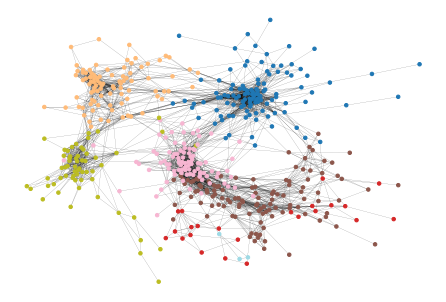

In [53]:
nx.draw(Gc_fmri,
        pos=spring_layout,
        node_size=12,
        width=0.1,
        cmap=plt.cm.tab20,
        node_color=[i for i in ml.membership])

## Node-level characteristics

### Node-level features

So far we have focused on features that describe the entire graph, like average clustering or average path length.  However, we are often also interested in describing the features of individual nodes in the network, which can be useful for describing their role.  In particular, we often want to characterize which are the most important nodes in the network, which is defined in graph theory by the concept of [Centrality](https://en.wikipedia.org/wiki/Centrality).  There are a number of other ways that centrality can be defined, which have been described as falling along two main dimensions (Borgatti & Everett, 2006).  First, we can divided measures based on the type of nodal involvement, between the paths that start or end at a particular node (known as *radial* centralities) and those that are based on the paths that go through a particular node (known as *medial* centralities).  Second, we can divide measures based on the quantity being assessed, either volume (e.g. number of connections) or length (e.g. distance between nodes).

When thinking about centrality measures it is important to keep in mind that different measures are sensitive to different aspects of a network, and they may not agree. 

A simple measure of centrality is *degree centrality* - which is simply the degree of the node (as we discussed earlier in the context of the Facebook dataset). This is a simple measure but can be quite useful in identifying which individuals are connected to the largest number of others.

Another measure of centrality is *closeness centrality* which is based on the average path length from a given node to all other nodes in the network.  This tells us which nodes have the potential to most quickly influence the rest of the network.

Yet another measure is *betweenness centrality*, which is based on the number of times that a node falls on the shortest path between two other nodes.  This tells us which nodes could potentially exert the strongest control on information flow over the network.

Finally, another popular measure is *eigenvector centrality*, which is related to degree centrality but instead of weighting each edge the same way, it provides more credit to nodes that are connected to other highly connected nodes.  Eigenvector centrality is closely related to the PageRank algorithm which is the basis for Google's search algorithms.

Let's compute all of these for the Facebook data - because these can take quite a while to compute, we will cache the results.


In [54]:
def scale_vector(v):
    """
    scale to go from zero to one
    """
    min, max = np.min(v), np.max(v)
    return((v - min)/(max - min))

centrality = {}
centrality['degree'] = nx.degree_centrality(Gc_fmri)

centrality['closeness'] = nx.closeness_centrality(Gc_fmri)
centrality['betweenness'] = nx.betweenness_centrality(Gc_fmri)
centrality['eigenvector'] = nx.eigenvector_centrality(Gc_fmri, max_iter=1000)
# save to data frame
centrality_df = pd.DataFrame(centrality)
# scale all to zero-one
for v in centrality_df.columns:
    centrality_df[v] = scale_vector(centrality_df[v])


Now let's look at how these different centrality measures are related to one another. Since these measures should really only be treated as ordinal (i.e. relative) variables, we will use rank correlation to compare them.

In [55]:
centrality_cc = centrality_df.corr(method='spearman')
centrality_cc

,degree,closeness,betweenness,eigenvector
degree,1.000000,0.564272,0.579958,0.492101
closeness,0.564272,1.000000,0.670969,0.872633
betweenness,0.579958,0.670969,1.000000,0.444076
eigenvector,0.492101,0.872633,0.444076,1.000000


We see that they are moderately correlated, suggesting that the different measures do indeed provide different information.  Let's plot the network using these indices to see if we can tell how they differ.

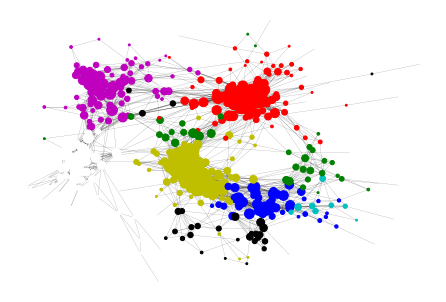

In [56]:
base_size=200
nx.draw(Gc_fmri,
        pos=spring_layout,
        node_size=base_size*centrality_df.loc[:, 'degree'],
        width=0.1,
        node_color=node_colors)

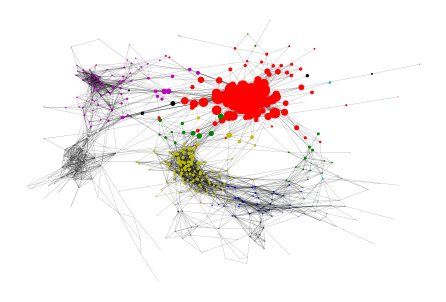

In [57]:
base_size=200
nx.draw(Gc_fmri,
        pos=spring_layout,
        node_size=base_size*centrality_df.loc[:, 'eigenvector'],
        width=0.1,
        node_color=node_colors)

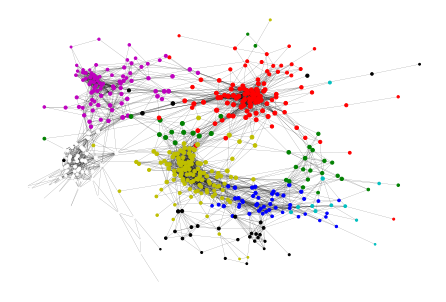

In [58]:
base_size=20
nx.draw(Gc_fmri,
        pos=spring_layout,
        node_size=base_size*centrality_df.loc[:, 'closeness'],
        width=0.1,
        node_color=node_colors)

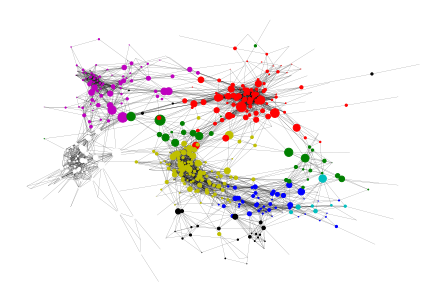

In [59]:
base_size=100
nx.draw(Gc_fmri,
        pos=spring_layout,
        node_size=base_size*centrality_df.loc[:, 'betweenness'],
        width=0.1,
        node_color=node_colors)

## Applying graph theory to behavioral data

A number of researchers have begun to use network analysis methods to examine behavioral data.  Here we will assess the use of these methods to look at relations between several sets of related variables in the SRO dataset, related to risk-taking, impulsivity, and delay discounting.

In [74]:
from data_utils import get_SRO_data
from sklearn.preprocessing import quantile_transform
# we need to use the imputed data because many subjects have missing values on at least
# one of these variables, so listwise deletion would greatly reduce the number of subjects
# it's worth keeping in mind that this would invalidate any crossvalidation, and will 
# likely increase the split-half reliability

SROdata = get_SRO_data(add_demog=False, use_imputed=True)

measures_to_keep = [# discounting
                    'bickel_titrator', 'kirby', 'discount_titrate',
                    # impulsivity
                    'bis11_survey', 'brief_self_control_survey',
                    'dickman_survey', 
                    # risk taking
                    'dospert_rt_survey', 'impulsive_venture_survey',
                    'upps_impulsivity_survey']

columns_to_keep = []
for c in SROdata.columns:
    for m in measures_to_keep:
        if c.find(m) > -1:
            columns_to_keep.append(c)
            
SROdata = SROdata[columns_to_keep]
SROtrans = quantile_transform(SROdata, copy=True, n_quantiles = SROdata.shape[0])
SROdata = pd.DataFrame(SROtrans,
                       index=SROdata.index,
                       columns=SROdata.columns)

0.42424242424242425


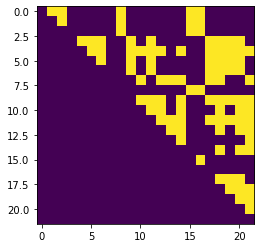

In [75]:
def get_corrmtx(data, method='pearson', use_abs=True, **kwargs):
    """
    get the correlation or inverse covariance matrix, depending
    on method
    
    parameters:
    ---------
    data: a pandas data frame
    method: one of:
        'pearson' for Pearson correlation
        'glasso' for graphical lasso
        'quic' for QUIC
    use_abs: return the absolute correlation/precision
    **kwargs: added arguments for the estimation functions
    
    returns:
    -------
    cc_df: a data frame containing the measure of interest
    """
    assert method in ['pearson', 'glasso', 'quic']
    assert type(data) == pd.core.frame.DataFrame
    n = data.shape[0]
    cc_df = data.corr()
    
    if method == 'glasso':
        model = GraphicalLassoCV(alphas=10, n_refinements=4, **kwargs)
        model.fit(data)
        cc = model.precision_

    elif method == 'quic':
        model = QuicGraphicalLassoCV()
        model.fit(data)
        cc = model.precision_

    elif method == 'pearson':
        cc = cc_df.values

    if use_abs:
        cc = np.abs(cc)

    cc_df = pd.DataFrame(cc,  
                         index=cc_df.index,
                         columns=cc_df.columns)
    return(cc_df)


def get_adjmtx(cc_df, density = None, alpha=None, n=None):
    """
    get adjacency matrix at a given density
    
    parameters:
    ----------
    cc_df: a data frame containing a correlation/covariance matrix
    density: intended density of the adjacency matrix
    alpha: fdr-corrected alpha level
    
    returns:
    --------
    adj_df: a pandas data frame with the binary density
    
    """
    
    assert (density is not None) ^ (alpha is not None)
    
    cc = cc_df.values
    cc_triu = cc[np.triu_indices_from(cc, 1)]
    
    if density is not None:
        cc_thresh = scipy.stats.scoreatpercentile(cc_triu,
                                                  100 - 100 * density)
        over_thresh = cc_triu >= cc_thresh
    else:
        assert n is not None
        tvals = (cc_triu * np.sqrt(n - 2))/np.sqrt(1 - cc_triu**2)
        pvals = 1 - scipy.stats.t.cdf(tvals, n - 2)
        over_thresh, fdrp = fdrcorrection(pvals, alpha)

    adj = np.zeros(cc.shape)
    adj[np.triu_indices_from(adj, 1)] = (over_thresh).astype(int)
    adj_df = pd.DataFrame(adj, 
                          index=cc_df.index,
                          columns=cc_df.columns)

    return(adj_df)

def get_adjmtx_density(adj_df):
    adj = adj_df.values
    adj_triu = adj[np.triu_indices_from(adj, 1)]
    return(np.mean(adj_triu))

cc_df = get_corrmtx(SROdata)
adj_sro_df = get_adjmtx(cc_df, alpha=0.001, n=SROdata.shape[0])
fdr_density = get_adjmtx_density(adj_sro_df)
print(fdr_density)
plt.imshow(adj_df.values)

In [76]:
# convert to networkx graph

def create_graph(adj_df, verbose=True):
    # create graph from adjacency matrix and compute modularity
    G = nx.Graph()

    for i, x in enumerate(adj_df.index):
            G.add_node(x)

    for i, x in enumerate(adj_df.index):
        for y in adj_df.index[i:]:
            if adj_df.loc[x, y] > 0:
                    G.add_edge(x, y)

    # get the giant component
    Gc = G.subgraph(max(nx.connected_components(G), key=len)).copy() 
    
    # compute modularity
    ig = nx_to_igraph(Gc) 

    ml=ig.community_multilevel()
    communities=np.unique(ml.membership)
    if verbose:
        print('Louvain method found %d communities'%len(communities))
        print(f'modularity = {ml.modularity}')
    return(Gc, ml)

Gc_sro, ml = create_graph(adj_sro_df)

Louvain method found 2 communities
modularity = 0.14167513427202774


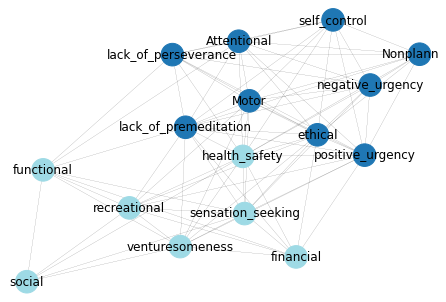

In [77]:
spring = nx.spring_layout(Gc_sro)

nx.draw(Gc_sro,
        pos=spring,
        node_size=510,
        width=0.1,
        cmap=plt.cm.tab20,
        node_color=[i for i in ml.membership],
        labels={i: i.split('.')[1] for i in Gc_sro.nodes})

In [78]:
## Compare to inverse covariance
icov_cc_df = get_corrmtx(SROdata, method='quic')
adj_sro_icov_df = get_adjmtx(icov_cc_df, fdr_density)

Gc_icov, ml_icov = create_graph(adj_sro_icov_df)

Louvain method found 3 communities
modularity = 0.1835172844648063


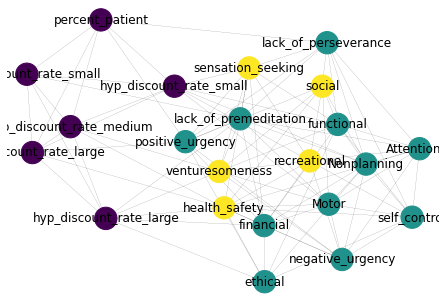

In [79]:
spring_icov = nx.spring_layout(Gc_icov)

nx.draw(Gc_icov,
        pos=spring_icov,
        node_size=500,
        width=0.1,
        node_color=[i for i in ml_icov.membership],
        labels={i: i.split('.')[1] for i in Gc_icov.nodes})


In [80]:
# assess reliability using split samples
# comparing pearson correlation to glasso
# fix density across methods and test across a range of densities

# use jaccard similarity to compare sets - size of union over size of intersection

n_splits = 100
densities = [0.02, 0.04, 0.06, 0.1, 0.2]
ss = ShuffleSplit(n_splits = n_splits, test_size=0.5)

reliabilities = pd.DataFrame({'density': np.zeros(n_splits * len(densities)),
                              'cc': np.zeros(n_splits * len(densities)),
                              'glasso': np.zeros(n_splits * len(densities)),
                              'quic': np.zeros(n_splits * len(densities))})
ctr = 0

for train_index, test_index in ss.split(SROdata):
    cc_train_df = get_corrmtx(SROdata.iloc[train_index, :])
    cc_test_df = get_corrmtx(SROdata.iloc[test_index, :])
    gl_train_df = get_corrmtx(SROdata.iloc[train_index, :], method='glasso', max_iter=2000)
    gl_test_df = get_corrmtx(SROdata.iloc[test_index, :], method='glasso', max_iter=2000)
    quic_train_df = get_corrmtx(SROdata.iloc[train_index, :], method='quic')
    quic_test_df = get_corrmtx(SROdata.iloc[test_index, :], method='quic')

    for density in densities:
        adj_train_df = get_adjmtx(cc_train_df, density=density)
        adj_train = adj_train_df.values
        adj_test_df = get_adjmtx(cc_test_df, density=density)
        adj_test = adj_test_df.values
        adj_glasso_train_df = get_adjmtx(gl_train_df, density=density)
        adj_glasso_train = adj_glasso_train_df.values
        adj_glasso_test_df = get_adjmtx(gl_test_df, density=density)
        adj_glasso_test = adj_glasso_test_df.values
        adj_quic_train_df = get_adjmtx(quic_train_df, density=density)
        adj_quic_train = adj_quic_train_df.values
        adj_quic_test_df = get_adjmtx(quic_test_df, density=density)
        adj_quic_test = adj_quic_test_df.values

        jacc_cc = jaccard_score(adj_train[np.triu_indices_from(adj_train, 1)],
                                adj_test[np.triu_indices_from(adj_test, 1)])
        jacc_glasso = jaccard_score(adj_glasso_train[np.triu_indices_from(adj_glasso_train, 1)],
                                    adj_glasso_test[np.triu_indices_from(adj_glasso_test, 1)])
        jacc_quic = jaccard_score(adj_quic_train[np.triu_indices_from(adj_quic_train, 1)],
                                    adj_quic_test[np.triu_indices_from(adj_quic_test, 1)])
        
        reliabilities.loc[ctr, :] = [density, jacc_cc, jacc_glasso, jacc_quic] 
        #print(ctr, reliabilities.loc[ctr, :].tolist())
        ctr += 1


/opt/conda/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -1.885e-04
  % (max_iter, d_gap), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.060e-04
  % (max_iter, d_gap), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -2.859e-04
  % (max_iter, d_gap), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 2.280e-04
  % (max_iter, d_gap), ConvergenceWarning)


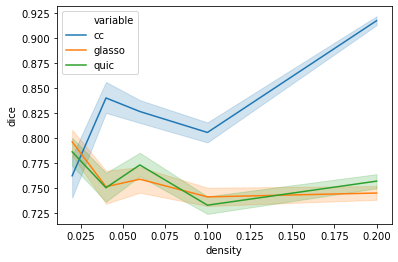

In [81]:
reliabilities_long = reliabilities.melt(id_vars='density', value_name = 'jaccard', value_vars=['cc', 'glasso', 'quic'])
reliabilities_long['dice'] = (2 * reliabilities_long['jaccard']) / (1 + reliabilities_long['jaccard'])
reliabilities_long.density = reliabilities_long.density.astype(float)

sns.lineplot(x='density', y='dice', hue='variable', data=reliabilities_long)